In [1]:
import numpy as np
import pandas as pd

from preprocessor import Preprocessor, PreprocessorCLI
from clusterer import Clusterer
from forecaster import ClusterForecaster, WorkloadGenerator

from matplotlib import pyplot as plt

### Generate sine wave time series

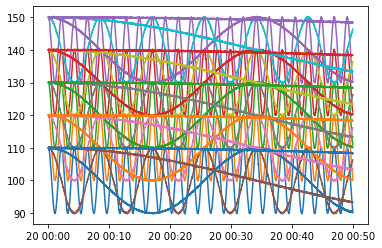

In [2]:
cluster_interval = pd.Timedelta(seconds=1)


def generate_cos_df(index, freq, amp, base, noise=0.0):
    n = len(index)
    wave = np.cos(np.arange(n) * 2 * np.pi / freq)
    wave += np.random.normal(size=n) * noise
    return pd.DataFrame(
        wave * amp + base,
        index=index, columns=['count'])


NUM_CLUSTERS = 5
TEMPLATE_PER_CLUSTER = 5
dtindex = pd.date_range(start="2021-12-20", end="2021-12-21",
                        freq=cluster_interval, name='log_time_s')

synthetic_templates = []

for i in range(NUM_CLUSTERS):
    for j in range(TEMPLATE_PER_CLUSTER):
        freq = 128*(4**i)
        amp = 10
        base = (j) * 10 + 100
        generated = generate_cos_df(dtindex, freq, amp, base, 0.01)

        plt.plot(generated.iloc[:3000])

        generated['query_template'] = "TEMPLATE_{}_{}".format(i, j)
        synthetic_templates.append(generated)

synthetic_groups = pd.concat(synthetic_templates).groupby(
    ["query_template", "log_time_s"]).sum()

plt.show()


### Clustering

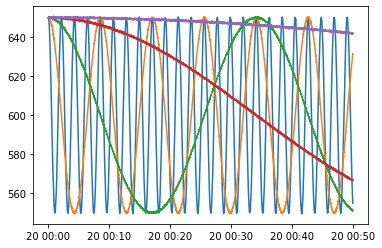

In [3]:
clusterer = Clusterer(synthetic_groups,rho=0.999,n_samples=1000)
assignment_df = clusterer.assignment_df

joined = synthetic_groups.join(assignment_df)
joined["cluster"].fillna(-1,inplace=True)
clustered_df = joined.groupby(["cluster", "log_time_s"]).sum()
cluster_dict = {}

labels = set(clustered_df.index.get_level_values(0).values)
for i in labels:
    cluster_counts = clustered_df[clustered_df.index.get_level_values(0)==i].droplevel(0).reindex(dtindex,fill_value=0)
    plt.plot(cluster_counts[:3000])
    cluster_dict[i] = cluster_counts

plt.show()

### Train Forecast Models

In [4]:
pred_seqlen = 10
pred_interval = pd.Timedelta(seconds=10)
pred_horizon = pd.Timedelta(seconds=60)

cluster_forecaster = ClusterForecaster(
    clustered_df,
    pred_seqlen,
    pred_interval,
    pred_horizon,
    "sine_models",
    override=True)


Training on cluster time series..
training model for cluster 0
Training with 8641 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00052117
[LSTM FIT]epoch:   2 loss: 0.00000039
[LSTM FIT]epoch:   3 loss: 0.00000027
[LSTM FIT]epoch:   4 loss: 0.00000133
[LSTM FIT]epoch:   5 loss: 0.00001344
[LSTM FIT]epoch:   6 loss: 0.00000402
[LSTM FIT]epoch:   7 loss: 0.00001214
[LSTM FIT]epoch:   8 loss: 0.00002274
[LSTM FIT]epoch:   9 loss: 0.00000459
[LSTM FIT]epoch:  10 loss: 0.00000010
[LSTM FIT]epoch:  10 loss: 0.0000001025
training model for cluster 1
Training with 8641 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00000108
[LSTM FIT]epoch:   2 loss: 0.00001127
[LSTM FIT]epoch:   3 loss: 0.00000223
[LSTM FIT]epoch:   4 loss: 0.00022376
[LSTM FIT]epoch:   5 loss: 0.00016373
[LSTM FIT]epoch:   6 loss: 0.00000101
[LSTM FIT]epoch:   7 loss: 0.00000049
[LSTM FIT]epoch:   8 loss: 0.00000282
[LSTM FIT]epoch:   9 loss: 0.01959960
[LSTM FIT]epoch:  10 loss: 0.00001216
[LSTM FIT]epoch:  10 loss: 0.0

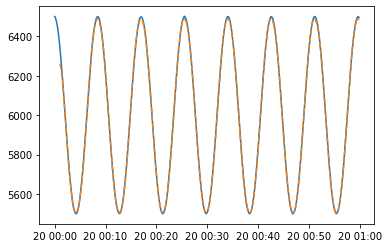

In [5]:
start_time = pd.Timestamp('2021-12-20 00:00:00')
end_time = pd.Timestamp('2021-12-20 01:00:00')
cluster = 1

result = cluster_forecaster.predict(clustered_df, cluster, start_time, end_time)

expected = clustered_df[clustered_df.index.get_level_values(0) == cluster].droplevel(0).resample(pred_interval).sum()
expected = expected[start_time:(end_time - pd.Timedelta(milliseconds = 1))]

plt.plot(expected)
plt.plot(result, "--")
plt.show()
